In [ ]:
! rm -rf data/lego-minifigures-classification
! pip install kaggle
! kaggle datasets download -d ihelon/lego-minifigures-classification -p data/
! unzip data/lego-minifigures-classification.zip -d data/lego-minifigures-classification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Archive:  data/lego-minifigures-classification.zip
  inflating: data/lego-minifigures-classification/LICENSE  
  inflating: data/lego-minifigures-classification/harry-potter/0001/001.jpg  
  inflating: data/lego-minifigures-classification/harry-potter/0001/002.jpg  
  inflating: data/lego-minifigures-classification/harry-potter/0001/003.jpg  
  inflating: data/lego-minifigures-classification/harry-potter/0001/004.jpg  
  inflating: data/lego-minifigures-classification/harry-potter/0001/005.jpg  
  inflatin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import shutil
import os
from PIL import Image

In [ ]:
train_set = pd.read_csv("data/lego-minifigures-classification/index.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
metadata = pd.read_csv("data/lego-minifigures-classification/metadata.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)

In [ ]:
root_path = "data/lego-minifigures-classification/"

In [ ]:
for i in list(train_set.itertuples()):
    path = i.path
    classe = i.class_id
    train_valid = i._4
    classe_name = metadata[metadata.class_id == classe].minifigure_name.values[0]
    if os.path.isdir(str(root_path)+str(train_valid)+"/"+str(classe_name)) is False:
        os.makedirs(str(root_path)+str(train_valid)+"/"+str(classe_name))
    shutil.move(str(root_path)+str(path), str(root_path)+str(train_valid)+"/"+str(classe_name)+"/"+str(path.split('/')[2]))

In [ ]:
batch_size = 10
train_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=str(root_path)+"train", target_size=(224,224), batch_size=batch_size)
valid_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=str(root_path)+"valid", target_size=(224,224), batch_size=batch_size)

Found 149 images belonging to 25 classes.
Found 138 images belonging to 25 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('loss')<=0.01):
          self.model.stop_training = True
input_shape = train_batches.image_shape
model = Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(25, activation='sigmoid'))
model.compile(optimizer=Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.fit(x=train_batches, epochs=200,callbacks=[myCallback()], validation_data=vald_batches)

Epoch 1/200
15/15 [==============================] - 12s 775ms/step - loss: 0.3910 - accuracy: 0.0403 - val_loss: 4.0216 - val_accuracy: 0.0652
Epoch 2/200
15/15 [==============================] - 11s 759ms/step - loss: 0.1594 - accuracy: 0.3087 - val_loss: 3.9145 - val_accuracy: 0.0362
Epoch 3/200
15/15 [==============================] - 11s 763ms/step - loss: 0.0977 - accuracy: 0.6040 - val_loss: 6.4589 - val_accuracy: 0.0362
Epoch 4/200
15/15 [==============================] - 11s 765ms/step - loss: 0.0526 - accuracy: 0.8322 - val_loss: 7.5602 - val_accuracy: 0.0362
Epoch 5/200
15/15 [==============================] - 11s 762ms/step - loss: 0.0289 - accuracy: 0.9262 - val_loss: 11.1162 - val_accuracy: 0.0362
Epoch 6/200
15/15 [==============================] - 11s 765ms/step - loss: 0.0213 - accuracy: 0.9597 - val_loss: 13.0964 - val_accuracy: 0.0362
Epoch 7/200
15/15 [==============================] - 11s 763ms/step - loss: 0.0183 - accuracy: 0.9530 - val_loss: 12.4463 - val_accura

In [ ]:
preds = model.predict_generator(valid_batches)

23


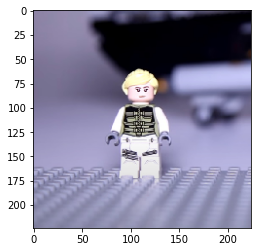

11


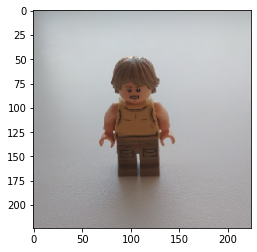

17


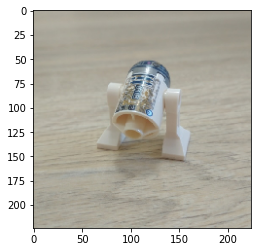

{'AUNT MAY': 0,
 'BLACK WIDOW': 1,
 'CAPTAIN AMERICA': 2,
 'CARA DUNE': 3,
 'FIREFIGHTER': 4,
 'GENERAL GRIEVOUS': 5,
 'GHOST SPIDER': 6,
 'HARRY POTTER': 7,
 'KLATOOINIAN RAIDER 1': 8,
 'KLATOOINIAN RAIDER 2': 9,
 'KYLO REN': 10,
 'LUKE SKYWALKER': 11,
 'MACE WINDU': 12,
 'MYSTERIO': 13,
 'OUTRIDER 1': 14,
 'OUTRIDER 2': 15,
 'OWEN GRADY': 16,
 'R2-D2': 17,
 'RON WEASLEY': 18,
 'SPIDER-MAN': 19,
 'TASKMASTER': 20,
 'THE MANDALORIAN': 21,
 'VENOM': 22,
 'YELENA BELOVA': 23,
 'YODA': 24}

In [ ]:
x,y = valid_batches.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print(np.argmax(label))
    plt.imshow(image)
    plt.show()
valid_batches.class_indices